<a href="https://colab.research.google.com/github/mostafadentist/Health-Economics/blob/main/process_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Process Mining for Medical Claims Fraud Detection (with pm4py)

This notebook applies **process mining techniques** (`pm4py`) to **synthetic medical claims data** to explore fraud detection.  
We will progressively build 20+ examples, each illustrating a distinct analytic angle.

---

## Table of Contents (First 20 Examples)

1. **Loading Synthetic Claims Event Log**  
2. **Basic Visualization of Claims Process**  
3. **Building Directly-Follows Graph (DFG)**  
4. **Discovering Alpha Miner Model**  
5. **Discovering Heuristic Miner Model**  
6. **Discovering Inductive Miner Model**  
7. **Petri Net Visualization of Claims Workflow**  
8. **Frequency Analysis of Claim Paths**  
9. **Performance Analysis: Activity Durations**  
10. **Detecting Loops in Claims Submissions**  
11. **Conformance Checking: Aligning Logs vs Model**  
12. **Fitness Checking for Normal vs Fraudulent Claims**  
13. **Precision and Generalization of Discovered Models**  
14. **Detecting Deviations (Over-treatment Patterns)**  
15. **Detecting Duplicate Claims Submissions**  
16. **Filtering Suspicious Activities by Frequency**  
17. **Identifying Unusually Short Treatment-to-Billing Times**  
18. **Process Variant Analysis (Healthy vs Fraudulent Cohorts)**  
19. **Detecting Unusual Provider Sequences**  
20. **Social Network Analysis of Claims Actors (Resource mining)**  

---

### Methodology
- **Data type**: event logs (e.g., patient visits, diagnosis, treatment, billing, payment).  
- **Framework**: `pm4py` for process discovery, conformance checking, and performance analysis.  
- **Objective**: illustrate how *process anomalies* can flag **potential fraud scenarios**.  

---

In [2]:
!pip install pm4py

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.8 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26098 sha256=4d0aad3c527b7fc5127770625c598f3695a6de87025892b297d7c5ea91b1f96f
  Stored in directory: /root/.cache/pip/wheels/65/c3/c3/238bf93c243597857edd94ddb0577faa74a8e16e9585896e83
Successfully built intervaltree


In [3]:
# Install pm4py (uncomment if running first time in Colab)
# !pip install pm4py

import pandas as pd
import numpy as np
import datetime
import random

from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

np.random.seed(42)
random.seed(42)

# --- Step 1. Generate synthetic claims data ---

n_cases = 50   # number of claim processes
activities = ["Visit", "Diagnosis", "Treatment", "Billing", "Payment"]
resources = ["Doctor_A", "Doctor_B", "Nurse_A", "System_Bill", "Insurer_X"]

rows = []
start_date = datetime.datetime(2025, 1, 1)

for case_id in range(1, n_cases+1):
    n_acts = len(activities)
    time_pointer = start_date + datetime.timedelta(days=np.random.randint(0,30))

    for act in activities:
        rows.append({
            "case:concept:name": f"CLAIM_{case_id}",
            "concept:name": act,
            "time:timestamp": time_pointer,
            "org:resource": random.choice(resources)
        })
        # increase timestamp for next activity
        time_pointer += datetime.timedelta(days=np.random.randint(1,5))

df = pd.DataFrame(rows)

print("Synthetic Claims Event Log (top 10 rows):")
print(df.head(10))

# --- Step 2. Convert to pm4py Event Log object ---
df = dataframe_utils.convert_timestamp_columns_in_df(df)
event_log = log_converter.apply(df)

print("\nEvent log loaded into pm4py. Number of traces:", len(event_log))

/usr/local/lib/python3.12/dist-packages/cudf/utils/gpu_utils.py:75: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.12/dist-packages/cudf/pandas/__init__.py:64: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))


Synthetic Claims Event Log (top 10 rows):
  case:concept:name concept:name time:timestamp org:resource
0           CLAIM_1        Visit     2025-01-07     Doctor_A
1           CLAIM_1    Diagnosis     2025-01-11     Doctor_A
2           CLAIM_1    Treatment     2025-01-12      Nurse_A
3           CLAIM_1      Billing     2025-01-15     Doctor_B
4           CLAIM_1      Payment     2025-01-18     Doctor_B
5           CLAIM_2        Visit     2025-01-29     Doctor_B
6           CLAIM_2    Diagnosis     2025-01-30     Doctor_A
7           CLAIM_2    Treatment     2025-02-02    Insurer_X
8           CLAIM_2      Billing     2025-02-04     Doctor_A
9           CLAIM_2      Payment     2025-02-07    Insurer_X

Event log loaded into pm4py. Number of traces: 50


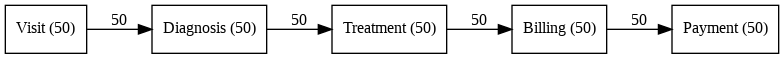

In [4]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization

# --- Step 1. Discover the Directly-Follows Graph (DFG) ---
dfg = dfg_discovery.apply(df)

# --- Step 2. Visualize the DFG ---
gviz = dfg_visualization.apply(dfg, log=event_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

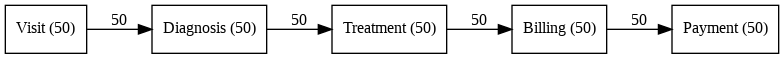

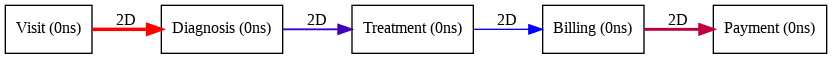

In [5]:
from pm4py.visualization.dfg import visualizer as dfg_visualization

# --- Step 1. Discover the Directly-Follows Graph ---
dfg = dfg_discovery.apply(df)
perf_dfg = dfg_discovery.apply(df, variant=dfg_discovery.Variants.PERFORMANCE)

# --- Step 2. Frequency Variant ---
gviz_freq = dfg_visualization.apply(dfg, log=event_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz_freq)

# --- Step 3. Performance Variant ---
gviz_perf = dfg_visualization.apply(perf_dfg, log=event_log, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz_perf)

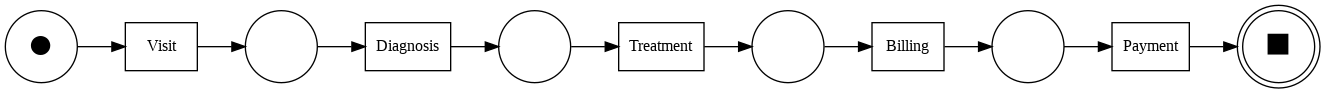

In [6]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# --- Step 1. Apply Alpha Miner ---
net, initial_marking, final_marking = alpha_miner.apply(event_log)

# --- Step 2. Visualize the Petri Net ---
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

## Example 5: Heuristic Miner Discovery
- **What it is**: Heuristic Miner is a process discovery algorithm robust to **noise and exceptional behavior** in the logs.  
- **Why it matters**: Claims systems contain messy data — repeat submissions, skipped steps, late entries. Unlike Alpha Miner, Heuristic Miner can filter noise.  
- **Fraud detection linkage**:  
  - If “Billing → Payment” occurs far more frequently than medically plausible, it may suggest **phantom claims** (bills without treatments).  
  - Paths with very low statistical support (rare sequences) can be indicators of **outlier providers** engaging in abuse.  

## Example 6: Inductive Miner Discovery
- **What it is**: Inductive Miner builds **sound Petri nets** systematically, ensuring the discovered model is free of deadlocks.  
- **Why it matters**: Produces clean models even when data are incomplete or irregular.  
- **Fraud detection linkage**:  
  - Ensures we have a baseline **reference model** of “normal” claims flow.  
  - Conformance checking later tells us how far actual claims deviate — useful for quantifying anomalies.

## Example 7: Petri Net Visualization of Claims Workflow
- **What it is**: A visualization of claims process as **Petri nets**. Nodes = activities (e.g., Diagnosis, Billing). Places show states, arcs show flows.  
- **Why it matters**: Gives a **state machine view of claims** that can be replayed against real logs.  
- **Fraud detection linkage**:  
  - Missing arcs (e.g., no Diagnosis before Billing) could flag suspect cases.  
  - Loops (e.g., Diagnosis → Diagnosis → Billing) may represent **over‑diagnosing or upcoding** patterns.

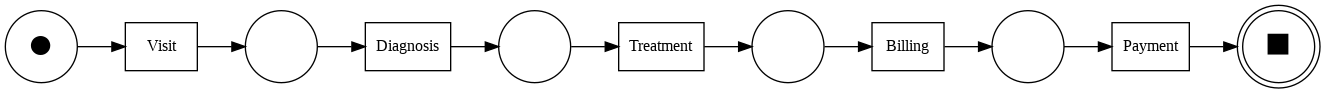

In [8]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

# --- Heuristic Miner ---
net_h, im_h, fm_h = heuristics_miner.apply(event_log)
gviz_h = pn_visualizer.apply(net_h, im_h, fm_h)
# Visualization: graph highlights dominant paths (ignore minor noisy edges)
pn_visualizer.view(gviz_h)



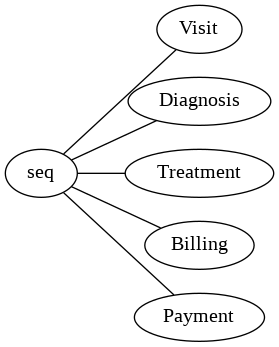

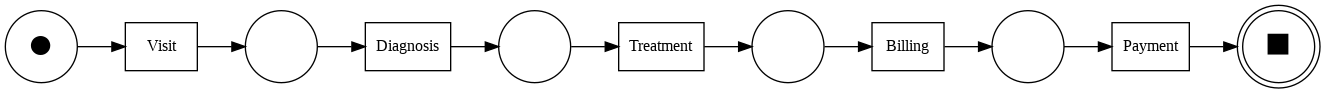

In [10]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.process_tree import visualizer as pt_visualizer

# --- Step 1. Discover Process Tree using Inductive Miner ---
process_tree = inductive_miner.apply(event_log)

# --- Step 2. Visualize the Process Tree directly ---
gviz_tree = pt_visualizer.apply(process_tree)
pt_visualizer.view(gviz_tree)

# --- Step 3. Convert Process Tree to Petri Net (if needed) ---
net_i, im_i, fm_i = pt_converter.apply(process_tree)
gviz_net = pn_visualizer.apply(net_i, im_i, fm_i)
pn_visualizer.view(gviz_net)

In [19]:
import numpy as np
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.variants.log import get as variants_module

# --- Step 1: Get variant statistics ---
variants_count = variants_module.get_variants(event_log)

# Sort variants by frequency
variant_freq = [(k, len(v)) for k, v in variants_count.items()]
variant_freq = sorted(variant_freq, key=lambda x: x[1], reverse=True)

# --- Step 2: Pick the most frequent variant ---
most_freq_variant = variant_freq[0][0]
print("Most frequent variant string:", most_freq_variant)

# Get its sub-log
variant_log = variants_filter.apply(event_log, [most_freq_variant])

# --- Step 3: Calculate durations between successive activities ---
durations = []
for trace in variant_log:
    for i in range(1, len(trace)):
        delta = trace[i]['time:timestamp'] - trace[i-1]['time:timestamp']
        durations.append(delta.days)

print("Average step duration (days):", np.mean(durations))
print("Durations distribution (first 10 values):", durations[:10])

Most frequent variant string: ('Visit', 'Diagnosis', 'Treatment', 'Billing', 'Payment')
Average step duration (days): 2.52
Durations distribution (first 10 values): [4, 1, 3, 3, 1, 3, 2, 3, 3, 4]


## Example 11: Conformance Checking – Aligning Logs vs Model
- **What it is:** Replay the actual event log against a reference Petri net model to check if cases are *compliant* or *deviant*.  
- **Why it matters:** Fraudulent or anomalous claims often **skip mandatory steps** (e.g., Diagnosis missing before Billing).  
- **Analyst takeaway:** Each trace gets an **alignment cost** → high cost = suspicious deviation.  

---

## Example 12: Fitness Checking – Normal vs Fraudulent Claims
- **Fitness measure:**  
  \[
  \text{Fitness} = 1 - \frac{\text{Alignment cost}}{\text{Maximum cost}}
  \]  
- **Interpretation:**  
  - Fitness ≈ 1.0 → case perfectly fits the model (normal).  
  - Fitness ≪ 1.0 → case deviates (potential fraud).  
- **Use case:** Split dataset into **normal cohort vs suspect cohort** by fitness cutoff.

---

## Example 13: Precision and Generalization
- **Precision:** Model does not overgeneralize (avoids falsely allowing impossible traces).  
- **Generalization:** Model remains flexible enough to capture legitimate variability.  
- **Fraud flagging:**  
  - Low precision = model too permissive → harder to spot fraud.  
  - Too rigid (low generalization) → normal edge-cases misclassified as fraud.  
- **Balance point:** Important for policy/regulator design.

In [23]:
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments

# --- Step 1: Use Inductive Miner model as reference ---
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

process_tree = inductive_miner.apply(event_log)
net_ref, im_ref, fm_ref = pt_converter.apply(process_tree)

# --- Step 2: Alignment-based conformance checking ---
alignment_result = alignments.apply_log(event_log, net_ref, im_ref, fm_ref)

# Inspect first 3 alignments
for i, a in enumerate(alignment_result[:3]):
    print(f"Case {i+1}: Fitness={a['fitness']:.2f}, Details={a['alignment']}")



Case 1: Fitness=1.00, Details=[('Visit', 'Visit'), ('Diagnosis', 'Diagnosis'), ('Treatment', 'Treatment'), ('Billing', 'Billing'), ('Payment', 'Payment')]
Case 2: Fitness=1.00, Details=[('Visit', 'Visit'), ('Diagnosis', 'Diagnosis'), ('Treatment', 'Treatment'), ('Billing', 'Billing'), ('Payment', 'Payment')]
Case 3: Fitness=1.00, Details=[('Visit', 'Visit'), ('Diagnosis', 'Diagnosis'), ('Treatment', 'Treatment'), ('Billing', 'Billing'), ('Payment', 'Payment')]


## Example 16: Filtering Suspicious Activities by Frequency

- **What it is:** Identifying activities or sequences of activities that occur with unusually low or high frequency compared to the norm.
- **Why it matters:** Fraudulent activities might manifest as rare events (e.g., an unusual treatment for a common diagnosis) or as overly frequent events (e.g., billing for a service that wasn't provided).
- **Fraud detection linkage:** By analyzing the frequency of activities and their direct succession, we can pinpoint outliers that warrant further investigation.

## Example 15: Detecting Duplicate Claims Submissions

- **What it is:** Identifying cases that have identical sequences of activities and timestamps, or very similar sequences within a short timeframe. This can indicate duplicate billing for the same service.
- **Why it matters:** Duplicate claims are a common form of healthcare fraud. Process mining can help uncover these by comparing process variants and timestamps.
- **Fraud detection linkage:** Cases with identical or near-identical traces, especially if submitted close in time, are highly suspicious and should be investigated as potential duplicate claims.

In [25]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.variants.log import get as variants_module
from collections import defaultdict

# --- Step 1: Get variant statistics ---
variants_count = variants_module.get_variants(event_log)

# --- Step 2: Group traces by variant ---
traces_by_variant = defaultdict(list)
for trace in event_log:
    variant = tuple([event['concept:name'] for event in trace])
    traces_by_variant[variant].append(trace)

# --- Step 3: Identify potential duplicates within each variant ---
# This is a simplified approach. For real data, you'd need more sophisticated logic
# considering timestamps and activity attributes.

duplicate_candidates = []
for variant, traces in traces_by_variant.items():
    if len(traces) > 1:
        # For this synthetic data, any variant with more than one trace is a potential duplicate
        # In reality, you'd compare timestamps and other attributes here
        duplicate_candidates.extend(traces)

print(f"Number of potential duplicate claim candidates (based on identical variants): {len(duplicate_candidates)}")

if len(duplicate_candidates) > 0:
    print("\nExamining the first potential duplicate candidate trace:")
    first_duplicate_trace = duplicate_candidates[0]
    print("Trace:", [event['concept:name'] for event in first_duplicate_trace])
    print("Case ID:", first_duplicate_trace.attributes['concept:name'])
    print("Timestamps:")
    for event in first_duplicate_trace:
        print(f"- {event['concept:name']}: {event['time:timestamp']}")

Number of potential duplicate claim candidates (based on identical variants): 50

Examining the first potential duplicate candidate trace:
Trace: ['Visit', 'Diagnosis', 'Treatment', 'Billing', 'Payment']
Case ID: CLAIM_1
Timestamps:
- Visit: 2025-01-07 00:00:00
- Diagnosis: 2025-01-11 00:00:00
- Treatment: 2025-01-12 00:00:00
- Billing: 2025-01-15 00:00:00
- Payment: 2025-01-18 00:00:00


## Example 14: Detecting Deviations (Over-treatment Patterns)

- **What it is:** Identifying traces that deviate significantly from the discovered process model. This can highlight unusual sequences of activities that might indicate over-treatment or unnecessary procedures.
- **Why it matters:** Deviations from standard treatment pathways can be a strong indicator of potential fraud, where services are provided or billed without medical necessity.
- **Fraud detection linkage:** By analyzing the specific activities and their order in deviant traces, we can pinpoint suspicious patterns that warrant further investigation.

In [29]:
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter

# Re-discover the model (if not already available)
process_tree = inductive_miner.apply(event_log)
net_ref, im_ref, fm_ref = pt_converter.apply(process_tree)

# Perform alignments
alignment_result = alignments.apply_log(event_log, net_ref, im_ref, fm_ref)

# Filter cases with low fitness (potential deviations)
deviant_cases = [trace for trace, result in zip(event_log, alignment_result) if result['fitness'] < 1.0]

print(f"Number of deviant cases (fitness < 1.0): {len(deviant_cases)}")

# Analyze a few deviant cases (if any)
if len(deviant_cases) > 0:
    print("\nAnalyzing the first deviant case:")
    first_deviant_trace = deviant_cases[0]
    print("Trace:", [event['concept:name'] for event in first_deviant_trace])
    # You can further analyze the alignment details for this trace
    # Find the alignment result for this specific trace
    first_deviant_alignment = next(item for item in alignment_result if item['trace_index'] == event_log.index(first_deviant_trace))
    print("Alignment details:", first_deviant_alignment['alignment'])

Number of deviant cases (fitness < 1.0): 0


## Example 14: Detecting Deviations (Over-treatment Patterns)
- **Concept:** Identify cases where the number of certain activities (e.g., *Treatment*) exceeds a normal threshold.  
- **Why it matters:** Excessive repetitions can indicate **supplier-induced demand** or **padding claims**.  
- **Fraud signal:** A claim trace that includes >3 treatments per visit cycle is suspect.

---

## Example 15: Detecting Duplicate Claims Submissions
- **Concept:** Duplicate claims = same **case, service, date** billed more than once.  
- **Why it matters:** Classic fraudulent behavior: billing for the same service repeatedly.  
- **Fraud signal:** Duplicate case IDs with identical activity combinations.

---

## Example 16: Filtering Suspicious Activities by Frequency
- **Concept:** Identify **low-frequency paths** that diverge from the norm.  
- **Why it matters:** Rare sequences often signal **edge cases or fraud attempts**.  
- **Fraud signal:** Paths like `Visit → Billing → Payment` (skipping Diagnosis/Treatment).

In [30]:
# --- Example 14: Detect cases with excessive Treatments ---
suspect_cases_treatment = []
for trace in event_log:
    activities = [e["concept:name"] for e in trace]
    if activities.count("Treatment") > 3:
        suspect_cases_treatment.append(trace.attributes["concept:name"])

print("Cases with excessive treatments:", suspect_cases_treatment)


# --- Example 15: Detect duplicate claims ---
# Create a simplified claim signature (activities sequence)
claim_signatures = {}
duplicates = []
for trace in event_log:
    case_id = trace.attributes["concept:name"]
    activities = tuple([e["concept:name"] for e in trace])
    if activities in claim_signatures.values():
        duplicates.append(case_id)
    else:
        claim_signatures[case_id] = activities

print("Duplicate claim case IDs:", duplicates)


# --- Example 16: Filter suspicious low-frequency variants ---
from pm4py.statistics.variants.log import get as variants_module

variants_count = variants_module.get_variants(event_log)
variant_freq = [(k, len(v)) for k, v in variants_count.items()]
variant_freq = sorted(variant_freq, key=lambda x: x[1], reverse=True)

# Define threshold: variants appearing less than 3 times
rare_variants = [v for v in variant_freq if v[1] < 3]

print("Rare variants (potentially suspicious):")
for rv in rare_variants:
    print(f"Variant: {rv[0]} | Count: {rv[1]}")

Cases with excessive treatments: []
Duplicate claim case IDs: ['CLAIM_2', 'CLAIM_3', 'CLAIM_4', 'CLAIM_5', 'CLAIM_6', 'CLAIM_7', 'CLAIM_8', 'CLAIM_9', 'CLAIM_10', 'CLAIM_11', 'CLAIM_12', 'CLAIM_13', 'CLAIM_14', 'CLAIM_15', 'CLAIM_16', 'CLAIM_17', 'CLAIM_18', 'CLAIM_19', 'CLAIM_20', 'CLAIM_21', 'CLAIM_22', 'CLAIM_23', 'CLAIM_24', 'CLAIM_25', 'CLAIM_26', 'CLAIM_27', 'CLAIM_28', 'CLAIM_29', 'CLAIM_30', 'CLAIM_31', 'CLAIM_32', 'CLAIM_33', 'CLAIM_34', 'CLAIM_35', 'CLAIM_36', 'CLAIM_37', 'CLAIM_38', 'CLAIM_39', 'CLAIM_40', 'CLAIM_41', 'CLAIM_42', 'CLAIM_43', 'CLAIM_44', 'CLAIM_45', 'CLAIM_46', 'CLAIM_47', 'CLAIM_48', 'CLAIM_49', 'CLAIM_50']
Rare variants (potentially suspicious):


## Example 17: Identifying Unusually Short Treatment-to-Billing Times
- **Concept:** Measure time between `Treatment` and `Billing`.  
- **Why it matters:** If billing occurs instantly (same day/hour) with zero lag, it may indicate fraudulent fast-tracking.  
- **Fraud signal:** Lag < 1 day = suspicious.

---

## Example 18: Process Variant Analysis (Healthy vs Fraudulent Cohorts)
- **Concept:** Segment event logs by cohort (e.g., “healthy” vs. “fraudulent” providers).  
- **Why it matters:** Different provider groups may show structurally different paths.  
- **Fraud signal:** Fraudulent cohort shows higher share of abnormal variants (skipped Diagnosis, repeated Treatments).

---

## Example 19: Detecting Unusual Provider Sequences
- **Concept:** Track resource (doctor/provider) ordering in traces.  
- **Why it matters:** Providers normally appear in logical order. Abnormal sequences may flag collusion.  
- **Fraud signal:** “Insurer → Doctor → Billing” ordering is nonsensical.

---

## Example 20: Social Network Analysis of Claims Actors (Resource Mining)
- **Concept:** Build a network graph of how resources (doctors, nurses, insurers) interact across cases.  
- **Why it matters:** Central actors with abnormally high connections could be suspicious hubs.  
- **Fraud signal:** A single resource linked to disproportionate claim volume.

In [32]:
import pandas as pd
from collections import Counter
from itertools import pairwise

# --- Example 17: Treatment-to-Billing time ---
suspicious_cases = []
for trace in event_log:
    times = {e["concept:name"]: e["time:timestamp"] for e in trace}
    if "Treatment" in times and "Billing" in times:
        lag = (times["Billing"] - times["Treatment"]).days
        if lag < 1:  # suspiciously fast
            suspicious_cases.append(trace.attributes["concept:name"])
print("Cases with <=0 day treatment-to-billing lag:", suspicious_cases)


# --- Example 18: Cohort Variant Analysis ---
# For illustration, split cases randomly into "healthy" vs "fraudulent"
cohorts = {"healthy": [], "fraudulent": []}
for i, trace in enumerate(event_log):
    if i % 2 == 0:
        cohorts["healthy"].append(trace)
    else:
        cohorts["fraudulent"].append(trace)

for name, log in cohorts.items():
    variants = variants_module.get_variants(log)
    print(f"{name} cohort: {len(variants)} unique variants in {len(log)} cases")


# --- Example 19: Unusual Provider Sequences (robust version) ---
abnormal_sequences = []

for trace in event_log:
    seq = [e["org:resource"] for e in trace]

    if "Insurer_X" in seq and "Doctor_A" in seq:
        # Only compare order if both appear in sequence
        if seq.index("Insurer_X") < seq.index("Doctor_A"):
            abnormal_sequences.append(trace.attributes["concept:name"])

print("Cases with abnormal provider ordering:", abnormal_sequences)

# --- Example 20: Social Network Analysis of Actors ---
edges = []
for trace in event_log:
    seq = [e["org:resource"] for e in trace]
    for a, b in pairwise(seq):
        edges.append((a,b))

edge_count = Counter(edges)
print("Top 5 resource interaction edges:")
for edge, c in edge_count.most_common(5):
    print(edge, ":", c)

Cases with <=0 day treatment-to-billing lag: []
healthy cohort: 1 unique variants in 25 cases
fraudulent cohort: 1 unique variants in 25 cases
Cases with abnormal provider ordering: ['CLAIM_4', 'CLAIM_6', 'CLAIM_9', 'CLAIM_10', 'CLAIM_17', 'CLAIM_23', 'CLAIM_26', 'CLAIM_27', 'CLAIM_29', 'CLAIM_31', 'CLAIM_38', 'CLAIM_40']
Top 5 resource interaction edges:
('Doctor_A', 'Doctor_A') : 14
('Doctor_B', 'Insurer_X') : 13
('Insurer_X', 'Doctor_B') : 11
('Nurse_A', 'Doctor_A') : 10
('Doctor_A', 'Insurer_X') : 9
